## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).

___________________________________________________________________________________________

# Questions à poser
- Est-ce qu'il est pertinent d'utiliser la cross-validation. Si oui, faut-il réunir train/test ou juste utiliser train?
    - Oui. Il faut réunir les données mais on peut en garder de côté pour une validation.
- Y a-t-il intérêt à normaliser les données?
    - Pertinent seulement s'il y a de grands écarts. Nécessaire pour sklearn.
- Faut-il optimiser le seuil de décision (0.5)?
    - Eventuellement (0.4-0.6 dizaine)
- Comment afficher la frontière de décision pour LDA?
    - plt.contour/contourf 
    - X, Y = meshgrid(x, y) où x, y sont des arange/linspace
    - f(X, Y) pour donner les valeurs (utiliser np.ravel pour vectoriser les matrices)

___________________________________________________________________________________________

# TODO
- Regarder si les classes sont déséquilibrées et l'influence que cela a sur le taux d'erreur
- Commentaires

In [257]:
from pylab import *
#import numpy as np
#import matplotlib.pyplot as plt
from numpy import linalg as la 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn as skl
import seaborn as sns

## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [258]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
    Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],)) # w initialisé comme vecteur nul de dimension le nombre d'attributs
    w_old = w 
    y = 1/2*np.ones((N_train,)) # on initialise l'activation ("w.x") à 0, y = sgm(wx) vaut alors 0.5
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n))
    z = X.dot(w_old)-la.inv(R).dot(y-t) # initialisation de z (old)
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z) # calcul de w pour la première étape avec les valeurs initialisées

    # boucle appliquant l'algorithme de Newton-Raphson
    Niter = 1 # on a déjà fait "l'itération 1"
    while  (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) : # condition d'arrêt: soit w et w_old sont suffisamment proches, soit on atteint un nombre maximum d'itérations
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w))) # on calcule y avec la fonction sigma
        R = np.diag(y*(1-y)) # par définition de R
        # on calcule ensuite z et w avec les formules données par la méthode de Newton-Raphson
        w_old = w 
        z = X.dot(w_old)-la.inv(R).dot(y-t)
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z)
         
    return w, Niter

### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [259]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:

In [260]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

### Exercise 1 : the logistic function of decision

1. Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 

### Q1: Estimate the logistic regression vector

In [261]:
w, Niter = regression_logistique(X, t, Nitermax=50)
print(f"The regression vector is {w} and was found in {Niter} iterations.")

The regression vector is [-15.206658    -7.91866363   6.56243114] and was found in 9 iterations.


### Q2: Compute the decision function


In [290]:
def sigma(a): return 1/(1+np.exp(-a)) # sigmoid function

class LogisticRegression():
    
    def __init__(self, train_data, train_target, threshold = 0.5, Nitermax = 50):
        self.train_data = train_data
        self.train_target = train_target
        self.threshold = threshold
        self.Nitermax = Nitermax
        
    def predict(self, test_data):
        coefs, _ = regression_logistique(self.train_data, self.train_target, self.Nitermax)
        pred = sigma(test_data.dot(coefs))
        return np.where(pred >= self.threshold, 1, 0)


In [291]:
logReg = LogisticRegression(X, t)
logReg.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1])

### Q3: Display results

With the goal to use cross-validation and compare with LDA later on, we create a utility class that will help us display data and predictions.

In [292]:
class BinaryPointsClassification():
    """Utility class to help with displaying prediction results and error rates.
    """

    def __init__(self, train_data, train_target, test_data, test_target, f_predict):
    
        self.train_data = train_data
        self.train_target = train_target
        self.test_data = test_data
        self.test_target = test_target
        self.f_predict = f_predict
        
        self.prediction = self.f_predict(test_data)
        self.errors, self.error_rate = self.__errors()
        
        self.confusion_matrix = skl.metrics.confusion_matrix(self.test_target, self.prediction)
        
        
    def __errors(self):
        """Returns the points that were classified wrongly and the error rate.
        """
        
        is_wrong_prediction = np.logical_or(np.logical_and(self.prediction[:] == 1, self.test_target[:] == 0), np.logical_and(self.prediction[:] == 0, self.test_target[:] == 1))
        errors = self.test_data[is_wrong_prediction, :][:,1:]
        error_rate = len(errors) / len(self.test_data)
        
        return errors, error_rate
    
    
    def predicted_points_figure(self, title=""):
        """Given a set of points and binary predictions (0-1), returns a graph showing the classification, crossing out the mistakes.
        """
        
        x_predicted_0 = self.test_data[self.prediction[:] == 0, :][:,1:]
        x_predicted_1 = self.test_data[self.prediction[:] == 1, :][:,1:]

        plt.scatter(x_predicted_0[:,0], x_predicted_0[:,1], c='r')
        plt.scatter(x_predicted_1[:,0], x_predicted_1[:,1], c='g')
        plt.scatter(self.errors[:,0], self.errors[:,1], c='b', marker = 'x')
        plt.title(title + "\n(mistakes are crossed out in blue)")
        
        
    def decision_regions_figure(self, x1_bounds, x2_bounds, resolution=1000):
        """Displays the decision regions for a given resolution (number of points along each axis).
        """

        x1 = np.linspace(x1_bounds[0], x1_bounds[1], resolution) 
        x2 = np.linspace(x2_bounds[0], x2_bounds[1], resolution) 
        X1, X2 = meshgrid(x1,x2)
        
        X = np.stack((np.ones(resolution**2), np.ravel(X1), np.ravel(X2))).T
        Z = self.f_predict(X).reshape(X1.shape)

        plt.contourf(X1, X2, Z, colors=['r', 'g', 'b', "y", 'purple'], alpha = 0.3) # extra colors are necessary otherwise everything is green and the boundary is red         
        
        
    def confusion_matrix_heatmap(self):
        """Displays the heatmap corresponding to the confusion matrix."""
        sns.heatmap(self.confusion_matrix, annot=True, fmt='d')      
         
        
    def display_prediction(self, x1_bounds, x2_bounds, resolution = 1000, figsize=(20,5) , title = "Classification"):
        """Convenient all-in-one display function. Displays the decision regions, the classified points (with mistakes) and the confusion matrix heatmap.
        """
        
        plt.figure(figsize=figsize)

        plt.subplot(121)
        self.predicted_points_figure(title)
        self.decision_regions_figure(x1_bounds, x2_bounds, resolution)

        plt.subplot(122)
        plt.title("Confusion matrix")
        self.confusion_matrix_heatmap()

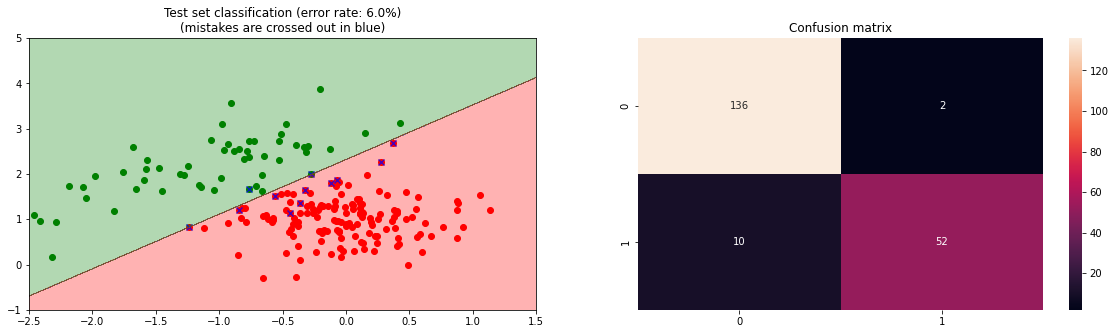

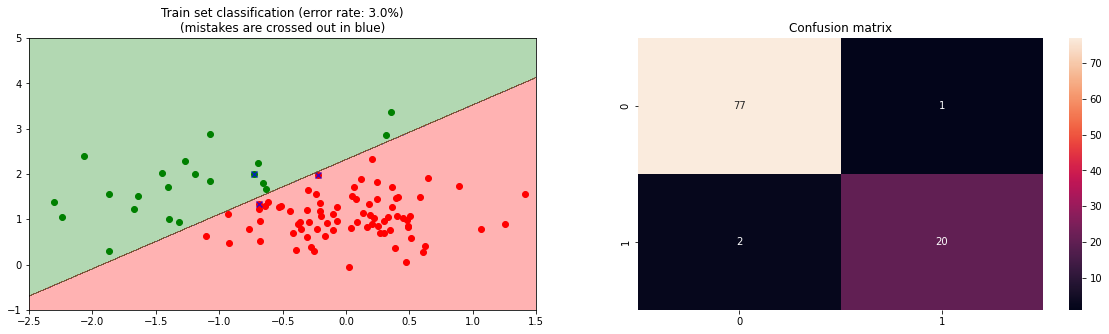

In [293]:
x1_bounds=(-2.5, 1.5)
x2_bounds=(-1, 5)
figsize=(20,5)

logReg = LogisticRegression(X, t)

# Results for the test set
classification_test = BinaryPointsClassification(X, t, X_test, t_test, logReg.predict)
classification_test.display_prediction(x1_bounds, x2_bounds, resolution = 1000, title = f"Test set classification (error rate: {classification_test.error_rate*100}%)")

# Results for the training set
classification_train = BinaryPointsClassification(X, t, X, t, logReg.predict)
classification_train.display_prediction(x1_bounds, x2_bounds, resolution = 1000, figsize = figsize, title = f"Train set classification (error rate: {classification_train.error_rate*100}%)")

## Q4: Equation of the decision boundary

The decision boundary corresponds to the $(x1,x2)$ couples such that $\sigma(w^T x) = 0$. In other words:  $w_0 + w_1 x_1 + w_2 x_2 = 0 $.

### Q5: Add a few points away from the decision boundary

In [294]:
nb_points = 10
outliers = np.stack([np.ones(nb_points), np.linspace(3,4,nb_points), np.linspace(-1,0,nb_points)]).T # generate 10 points far from the decision boundary

X_outliers = np.vstack([X, outliers])
t_outliers = np.hstack([t, np.zeros(nb_points)]) # all added points are in class 0

In [295]:
# Training the LDA model

lda = LinearDiscriminantAnalysis()
lda.fit(X_outliers, t_outliers)

LinearDiscriminantAnalysis()

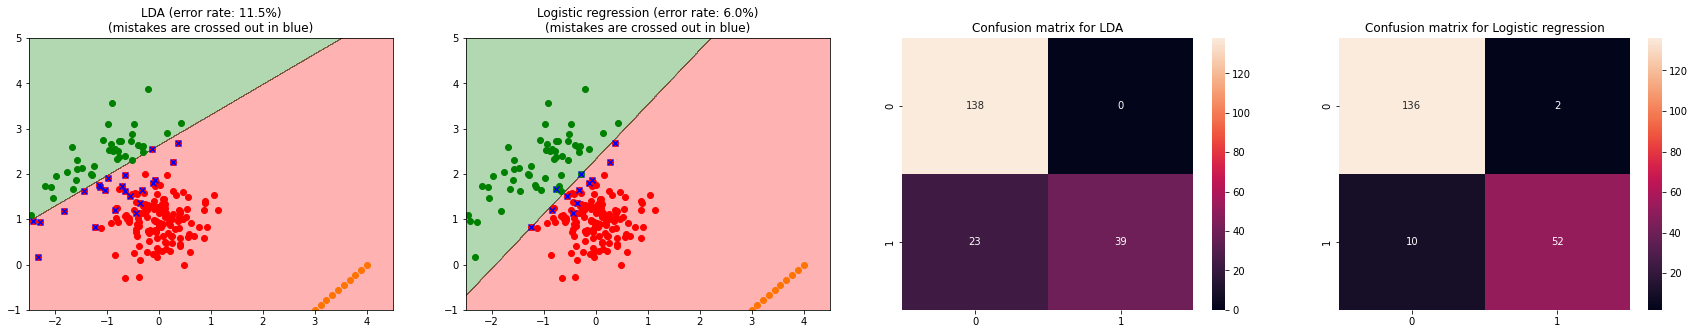

In [296]:
# Displaying results

x1_bounds = (-2.5, 4.5)
x2_bounds=(-1, 5)

classification_outliers = BinaryPointsClassification(X_outliers, t_outliers, X_test, t_test, logReg.predict)
classification_outliers_lda = BinaryPointsClassification(X_outliers, t_outliers, X_test, t_test, lda.predict)

plt.figure(figsize=(30,5))

plt.subplot(141)
plt.scatter(outliers[:,1], outliers[:,2], c='orange')
classification_outliers_lda.decision_regions_figure(x1_bounds, x2_bounds)
classification_outliers_lda.predicted_points_figure(title=f"LDA (error rate: {classification_outliers_lda.error_rate*100}%)")

plt.subplot(142)
plt.scatter(outliers[:,1], outliers[:,2], c='orange')
classification_outliers.decision_regions_figure(x1_bounds, x2_bounds)
classification_outliers.predicted_points_figure(title=f"Logistic regression (error rate: {classification_outliers.error_rate*100}%)")

plt.subplot(143)
plt.title("Confusion matrix for LDA")
classification_outliers_lda.confusion_matrix_heatmap()

plt.subplot(144)
plt.title("Confusion matrix for Logistic regression")
classification_outliers.confusion_matrix_heatmap()


# --- TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO ---

### Extra: Cross-validation

In order to better estimate the error rate and find an optimal threshold, we realize a cross validation.

# --- TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO ---

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [297]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images

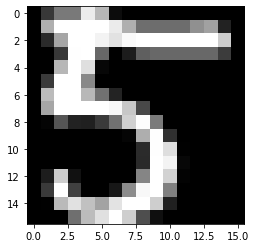

In [298]:
# Digit 5
n=9
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

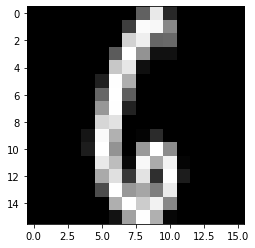

In [299]:
# Digit 6
n=5;
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:

In [272]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones((345,1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.

### Q1: Minimum and maximum pixel values

In [273]:
print(f"The pixel values are between {np.min(I[:])} and {np.max(I[:])}.")

The pixel values are between -1.0 and 1.0.


### Q2: Identify the most significant pixels

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://www.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

In [274]:
# Include your code here
from sklearn.linear_model import LogisticRegression
# ...

Commentaires :